## Compare variants

### 1. For each clone-variant, calculate the mean af difference between that clone-variant and other clone-variant
### 2. Sort the variants by ranking
### 3. Calculate the position of each clone's variant in the rankings 
### 4. Plot: each clone's mean ranking of the variants of interest 
### 5. Metric: 1/(Average ranking of variants in clone)

In [1]:
### Simulation parameters
n_donors = 2
n_conditions = 3
n_cells_per_donor_cond = 300
n_clones_in_don = 5
n_positions = 100
n_variants_per_clone_lambda = 1
n_donor_variants = 10

seq_error = 0.01
don_var_lim=(0.8,1)
clone_var_lim=(0.1,0.4)
depth_lim = (4,10)
chars = ["A", "G", "C", "T"]


ref_fa = "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"
dirs = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/Control/MT/cellr_True/numread_200/"

pileups_indir = "/data/Mito_Trace/output/clone_pileups_simulation/"
predict_indir =  "/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/knn/kparam_30/"

outdir =  "/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/knn/kparam_30/pred_vs_known/"
to_test = False



In [2]:
from Bio import SeqIO

import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join, exists
import os
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline
import mplh.cluster_help as ch

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=16)



import mplh.cluster_help as ch

fig_utils from mplh
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
params = {"donors":n_donors,"conditions":n_conditions, "cells_per_donor_cond":n_cells_per_donor_cond,
         "clones_in_don":n_clones_in_don, "positions":n_positions, 
          "variants_per_clone_lambda":n_variants_per_clone_lambda, "donor_variants":n_donor_variants}


seq_params = {"seq_error": seq_error, "don_var_lim":"_".join(np.array(don_var_lim).astype(str)), 
              "clone_var_lim": "_".join(np.array(clone_var_lim).astype(str)),
             "depth_lim":"_".join(np.array(depth_lim).astype(str))}

curr_out_meta = ""
for p in params:
    curr_out_meta = f"{curr_out_meta}__{p}_{params[p]}"

curr_out_meta = curr_out_meta.strip("__")
print(curr_out_meta)


curr_out_seq = ""
for p in seq_params:
    curr_out_seq = f"{curr_out_seq}__{p}_{seq_params[p]}"
curr_out_seq = curr_out_seq.strip("__")
print(curr_out_seq)


curr_pileups_indir = join(pileups_indir, curr_out_meta, curr_out_seq)



donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10
seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10


## Load data

In [4]:
#ref_char = np.random.choice(chars, n_positions)
ref_char = list(str(SeqIO.to_dict(SeqIO.parse(ref_fa, "fasta"))["chrM"].seq))

ref = [f"{i}_{c}" for i, c in enumerate(ref_char)]

ref_df = pd.DataFrame(np.array([range(len(ref_char)),ref_char]).transpose(),index=ref, columns=["pos", "ref"])
ref_df.head()

,pos,ref
0_G,0,G
1_A,1,A
2_T,2,T
3_C,3,C
4_A,4,A


In [5]:
don_vars_df = pd.read_csv(join(curr_pileups_indir, "donor_vars.csv"), index_col=0)
clone_vars_df = pd.read_csv(join(curr_pileups_indir, "clone_vars.csv"), index_col=0)
all_cells_df = pd.read_csv(join(curr_pileups_indir, "cells_meta.csv"), index_col=0)
clones_meta_cond_df = pd.read_csv(join(curr_pileups_indir, "clones_meta.csv"), index_col=0)

In [6]:
clone_vars_df["id"] = clone_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
don_vars_df["id"] = don_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
vars_of_interest = pd.concat([clone_vars_df.set_index("id"),don_vars_df.set_index("id")], axis=0)
vars_of_interest = vars_of_interest[["donor", "clone"]]
vars_of_interest.index = [x.replace(">","") for x in vars_of_interest.index]
clone_vars = vars_of_interest[(~(vars_of_interest["clone"].isnull()))].astype(object)

#clone_vars["lineage"] = clone_vars["clone"].apply(lambda x: x.split("cl")[-1]).astype(object)
#clone_vars["name"] = clone_vars.apply(lambda x: f'{x["donor"]}_{x["lineage"]}',axis=1)
clone_vars

,donor,clone
7369T,0,d0cl0
6842A,0,d0cl0
7151T,0,d0cl1
15306G,0,d0cl1
4225C,0,d0cl2
2841C,0,d0cl2
5663G,0,d0cl2
2549A,0,d0cl3
1972G,0,d0cl3
15378A,0,d0cl3


In [7]:
predict_barcodes_d = {}
for d in range(n_donors):
    predict_barcodes_d[str(d)] = pd.read_csv(join(predict_indir, f"barcodes/btwnClones_dendro_dt_0.6/donor{d}.mean.csv"), 
                                        index_col=0)

    if ">" in predict_barcodes_d[str(d)].columns[0]:
        # mgatkdonor 
        predict_barcodes_d[str(d)].columns = [x.split(">")[0][:-1] +  x.split(">")[-1] for x in predict_barcodes_d[str(d)].columns]

In [8]:
def calc_mean_diff(barcode_ser, clone_id):
    return (barcode_ser.loc[clone_id] - barcode_ser.drop(clone_id)).mean()

def get_var_clone(var_ser, barcodes_d):
    d_max = -1
    cl_max = -1
    max_diff = -np.infty
    for d in barcodes_d:
        if var_ser.name in barcodes_d[d].columns:
            curr_barcode = barcodes_d[d][var_ser.name]
            clone_diffs = []

            for curr_cl in curr_barcode.index:
                clone_diffs.append(calc_mean_diff(curr_barcode,curr_cl))
            print('clone_diffs',  max(clone_diffs))
            curr_max = max(clone_diffs)
            if curr_max>max_diff:
                cl_max = curr_barcode.index[np.array(clone_diffs).argmax()]
                max_diff = curr_max
                d_max = d
        
    return pd.Series({"pred_donor":str(d_max), "pred_clone":cl_max, "pred_diff": max_diff })




In [9]:
pred_clone_vars = clone_vars.apply(get_var_clone, args=(predict_barcodes_d,),axis=1, result_type='expand')
clone_vars = pd.concat((clone_vars,pred_clone_vars),axis=1)
clone_vars

clone_diffs 0.5253163958958624
clone_diffs 0.5286243135321703
clone_diffs 0.5265508458085415
clone_diffs 0.5306161121471429
clone_diffs 0.5276490428759957
clone_diffs 0.5200578727978034
clone_diffs 0.528186720226591
clone_diffs 0.5290924773695465
clone_diffs 0.5237790576507231
clone_diffs 0.524437928863051
clone_diffs 0.42074322235531875
clone_diffs 0.5139915718050322
clone_diffs 0.5233879611421842
clone_diffs 0.5186094932095953
clone_diffs 0.5333314050239507
clone_diffs 0.5364678998921476
clone_diffs 0.4796602603297341
clone_diffs 0.48416941638529915
clone_diffs 0.4848568412980086


,donor,clone,pred_donor,pred_clone,pred_diff
7369T,0,d0cl0,0,0_1,0.525316
6842A,0,d0cl0,0,0_9,0.528624
7151T,0,d0cl1,0,0_3,0.526551
15306G,0,d0cl1,0,0_7,0.530616
4225C,0,d0cl2,0,0_6,0.527649
2841C,0,d0cl2,0,0_5,0.520058
5663G,0,d0cl2,0,0_10,0.528187
2549A,0,d0cl3,0,0_11,0.529092
1972G,0,d0cl3,0,0_0,0.523779
15378A,0,d0cl3,0,0_2,0.524438


In [10]:
def get_rank_var_clone(var_ser, barcodes_d):
    if var_ser['pred_donor'] == "-1":
        return -1
    curr_d = var_ser['pred_donor']
    #print('curr_d', curr_d)
    curr_cl = var_ser['pred_clone']
    curr_v = var_ser.name
    curr_diff = var_ser["pred_diff"]
    #"Loop through each variant and calculate this clones fold for each, then see where it ranks"
    cl_ranks = []
    #print('curr_d',curr_d)
    for v in barcodes_d[curr_d].columns: 
        cl_ranks.append(calc_mean_diff(barcodes_d[curr_d][v], curr_cl))
    cl_ranks = np.array(cl_ranks)
    
    return (curr_diff <= cl_ranks).sum()
    
clone_vars["rank"] = clone_vars.apply(get_rank_var_clone,args=(predict_barcodes_d,),axis=1)
clone_vars

,donor,clone,pred_donor,pred_clone,pred_diff,rank
7369T,0,d0cl0,0,0_1,0.525316,1
6842A,0,d0cl0,0,0_9,0.528624,1
7151T,0,d0cl1,0,0_3,0.526551,1
15306G,0,d0cl1,0,0_7,0.530616,1
4225C,0,d0cl2,0,0_6,0.527649,1
2841C,0,d0cl2,0,0_5,0.520058,1
5663G,0,d0cl2,0,0_10,0.528187,1
2549A,0,d0cl3,0,0_11,0.529092,1
1972G,0,d0cl3,0,0_0,0.523779,1
15378A,0,d0cl3,0,0_2,0.524438,1


In [11]:
predict_barcodes_df = pd.concat(predict_barcodes_d).droplevel(0).fillna(0)
predict_barcodes_df

,13461A,15306G,7151T,1972G,2549A,15378A,2841C,4225C,5663G,6842A,7369T,6232G,6290A,1417G,11981T,904T,11719C,12622C,2041G
lineage,,,,,,,,,,,,,,,,,,,
0_11,0.000000,0.000000,0.000000,0.492623,0.588628,0.572812,0.000000,0.000000,0.000000,0.000000,0.000112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0_0,0.000000,0.000000,0.000000,0.582536,0.571942,0.499172,0.000095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0_2,0.000000,0.000000,0.000000,0.564782,0.499272,0.584005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.460984,0.587078,0.568018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0_10,0.000000,0.000000,0.000000,0.000000,0.000434,0.000109,0.564187,0.493227,0.589012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0_5,0.000000,0.000000,0.000000,0.000081,0.000000,0.000000,0.577025,0.576490,0.526839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0_3,0.000000,0.515934,0.587071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0_12,0.000000,0.579167,0.574421,0.000000,0.000000,0.000112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0_7,0.000000,0.591455,0.514945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
clone_vars = clone_vars.loc[~(clone_vars["pred_diff"] == -np.infty)]


In [13]:
clone_vars

,donor,clone,pred_donor,pred_clone,pred_diff,rank
7369T,0,d0cl0,0,0_1,0.525316,1
6842A,0,d0cl0,0,0_9,0.528624,1
7151T,0,d0cl1,0,0_3,0.526551,1
15306G,0,d0cl1,0,0_7,0.530616,1
4225C,0,d0cl2,0,0_6,0.527649,1
2841C,0,d0cl2,0,0_5,0.520058,1
5663G,0,d0cl2,0,0_10,0.528187,1
2549A,0,d0cl3,0,0_11,0.529092,1
1972G,0,d0cl3,0,0_0,0.523779,1
15378A,0,d0cl3,0,0_2,0.524438,1


Using only 16 of the labels for legend


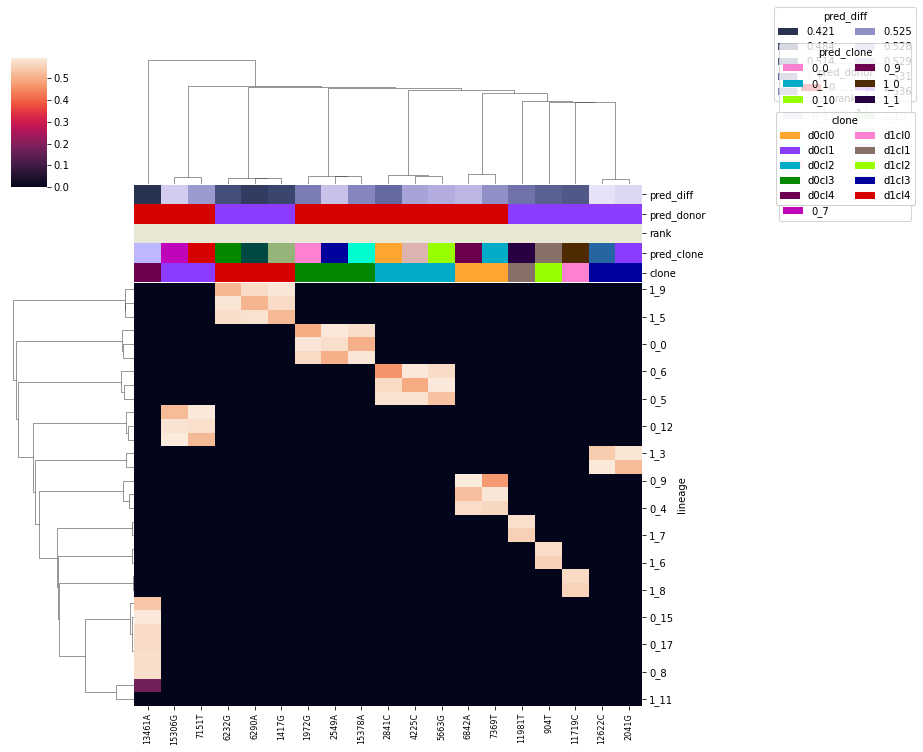

In [17]:
if clone_vars.shape[0] != 0:
    ch.plot_cluster(predict_barcodes_df.fillna(0), 
                    col_meta=clone_vars[["pred_diff","pred_donor","rank", "pred_clone", "clone"]], 
                    col_clr_schemes={"pred_diff":"sequential", "pred_clone":"categorical",
                                     "pred_donor":"categorical","clone":"categorical",
                                      "rank":"sequential"})

    #"pred_clone"

## Variants of same position!